In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import sys
import json
import pickle
from pathlib import Path
sys.path.append('/Users/philvanlane/Documents/lc_ae/convolution')
sys.path.append('/Users/philvanlane/Documents/lc_ae')
from conv_models import PowerSpectrumUNetAutoencoder, PowerSpectrumConfig
import time
from data_prep import normalize_ps, normalize_acf, block_mask, block_predefined_mask

proj_folder = '/Users/philvanlane/Documents/lc_ae/'
conv_folder = proj_folder + 'convolution/'
artifact_folder = conv_folder + 'model_artifacts/'

### Get data

In [3]:
with open(proj_folder + 'pk_star_sector_f_p_fs.pickle', 'rb') as f:
    data = pickle.load(f)

In [4]:
power = np.array([data[k]['power'] for k in data.keys()]).astype(np.float32)
f_stat = np.array([data[k]['f_stat'] for k in data.keys()]).astype(np.float32)
acf = np.array([data[k]['acf'] for k in data.keys()]).astype(np.float32)

power_dataset = torch.from_numpy(power).float()
f_stat_dataset = torch.from_numpy(f_stat).float()
acf_dataset = torch.from_numpy(acf).float()

In [ ]:
def getPowerSpectra():
    with open(proj_folder + 'pk_star_lc_cf_norm.pickle', 'rb') as f:
        data = pickle.load(f)
    ps = np.array([data[k]['power_1024_norm'] for k in data.keys()])
    ps = ps.astype(np.float32)
    return ps


In [3]:
# Get raw power spectra and ACF
ps_data = getPowerSpectra()
acf_data = np.fft.ifft(ps_data, axis=1).real

norm_ps = np.array([normalize_ps(ps_data[i],scale_factor=50) for i in range(len(ps_data))])
norm_acf = np.array([normalize_acf(acf_data[i],scale_factor=0.001) for i in range(len(acf_data))])

ps_dataset = torch.from_numpy(norm_ps).float()
acf_dataset = torch.from_numpy(norm_acf).float()

### Training

In [5]:
def trainUNetAE(model_config, train_config,dataset):
    """Quick training example with minimal setup"""
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print(f"Data shape: {dataset.shape}")
    
    # Split into train/val
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)
    
    # Choose loss function
    criterion = nn.MSELoss()
    
    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
    
    # Create UNet model
    config = PowerSpectrumConfig(
        input_length=model_config['input_length'],
        encoder_dims=model_config['encoder_dims'],
        num_layers=model_config['num_layers'],
        activation=model_config['activation']
    )
    
    model = PowerSpectrumUNetAutoencoder(config)
    model = model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), 
                                  lr=train_config.get('lr', 1e-3), 
                                  weight_decay=train_config.get('weight_decay', 1e-4))
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    print(f"UNet model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # 5. Training loop
    epochs = train_config['epochs']
    train_losses = []
    val_losses = []
    learning_rates = []
    best_val_loss = float('inf')
    
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:

            # Masking

            masked_batch, mask = block_predefined_mask(batch,
                                            block_size=train_config['mask_block_size'],
                                            mask_ratio=train_config['mask_ratio'])

            masked_batch = masked_batch.to(device)
            
            optimizer.zero_grad()
            output = model(masked_batch)
            loss = criterion(output['reconstructed'], batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                output = model(batch)
                loss = criterion(output['reconstructed'], batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
        
        if (epoch + 1) % 10 == 0 or epoch == epochs - 1 or epoch == 0:
            print(f"Epoch {epoch+1:3d}: Train Loss = {train_loss:.6f}, Val Loss = {val_loss:.6f}, LR = {optimizer.param_groups[0]['lr']:.2e}")
    
        
    # Load best model
    model.load_state_dict(best_model_state)

    print(f"Training completed!")
    print(f"Final validation loss: {val_losses[-1]:.6f}")

    return model, train_losses, val_losses, learning_rates



### Train

In [10]:
version = 'v07'
datatype = 'ps'
if datatype == 'ps':
    dataset = power_dataset
elif datatype == 'acf':
    dataset = acf_dataset
elif datatype == 'fs':
    dataset = f_stat_dataset
model_config = {
    'input_length': 16000,
    'encoder_dims': [4,8,16,32],
    'num_layers': 4,
    'activation': 'gelu'
}
train_config = {
    'mask_block_size': 50,
    'mask_ratio': 0.5,
    'batch_size': 32,
    'epochs': 20,
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'train_split': 0.8
}

Using device: cpu
Data shape: torch.Size([7911, 16000])
Training samples: 6328, Validation samples: 1583
Using Power Spectrum UNet encoder with activation: gelu
Expected bottleneck spatial size: 1000
Using Power Spectrum UNet decoder with activation: gelu
UNet model parameters: 30,175
Starting training for 20 epochs...
Epoch   1: Train Loss = 0.006092, Val Loss = 0.001850, LR = 1.00e-03
Epoch  10: Train Loss = 0.000784, Val Loss = 0.000175, LR = 1.00e-03
Epoch  20: Train Loss = 0.000680, Val Loss = 0.000255, LR = 5.00e-04
Training completed!
Final validation loss: 0.000255


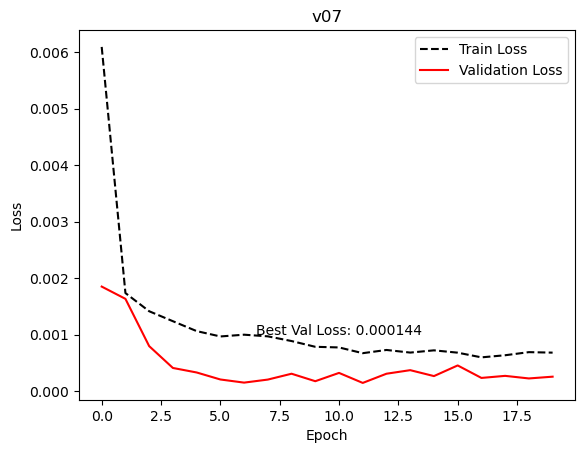

In [11]:
# Run the quick training example
model, train_losses, val_losses, learning_rates = trainUNetAE(model_config, train_config, dataset)

if datatype == 'ps':
    save_folder = artifact_folder + "ps/"
elif datatype == 'acf':
    save_folder = artifact_folder + "acf/"
elif datatype == 'fs':
    save_folder = artifact_folder + "fs/"

# Save parameters
torch.save(model.state_dict(), save_folder + version + "_conv_ae.pt")
np.save(save_folder + version + "_training_data.npy", np.array([train_losses,val_losses,learning_rates]))

# Save configs
log_data = {
    'version': version,
    'datatype': datatype,
    'model_config': model_config,
    'train_config': train_config,
    'final_train_loss': train_losses[-1],
    'final_val_loss': val_losses[-1],
    'num_parameters': sum(p.numel() for p in model.parameters()),
    # 'compression_ratio': model.get_compression_ratio()
}

with open(f"{save_folder}{version}_config_log.json", "w") as f:
    json.dump(log_data, f, indent=2)


# Plot
plt.plot(train_losses, label='Train Loss',color='black',linestyle='dashed')
plt.plot(val_losses, label='Validation Loss',color='red')
best_val_loss = min(val_losses)
plt.text(train_config.get('epochs')/2, (max(val_losses) + best_val_loss)/2,
         f'Best Val Loss: {best_val_loss:.6f}', fontsize=10, ha='center')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(version)
plt.legend()
plt.savefig(save_folder + version + "_losses.png")
plt.show()

## Recreate Data

### Recreate model

In [14]:
version = 'v07'
save_folder = artifact_folder + "ps/"
dataset = power_dataset

with open(f"{save_folder}{version}_config_log.json", "r") as f:
    log_data = json.load(f)

config = PowerSpectrumConfig(
    input_length=log_data['model_config']['input_length'],
    encoder_dims=log_data['model_config']['encoder_dims'],
    num_layers=log_data['model_config']['num_layers'],
    activation=log_data['model_config']['activation']
)

model = PowerSpectrumUNetAutoencoder(config)
model.load_state_dict(torch.load(save_folder + version + "_conv_ae.pt"))

Using Power Spectrum UNet encoder with activation: gelu
Expected bottleneck spatial size: 1000
Using Power Spectrum UNet decoder with activation: gelu


<All keys matched successfully>

### Plot random reconstruction (without masking)

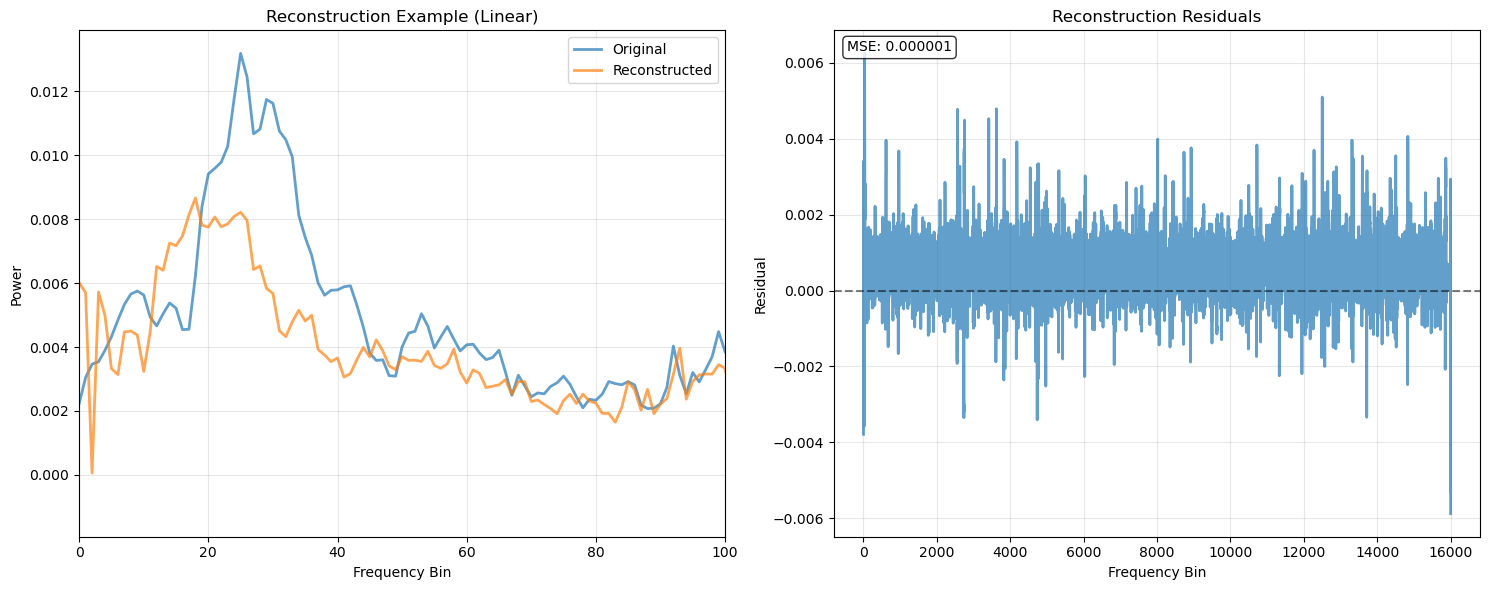

In [53]:
model.eval()

# New test data
loader = DataLoader(dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    sample_batch = next(iter(loader))[:1].to('cpu')
    output = model(sample_batch)
    
    original = sample_batch[0].cpu().numpy()
    reconstructed = output['reconstructed'][0].cpu().numpy()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Linear scale reconstruction
axes[0].plot(original, label='Original', alpha=0.7, linewidth=2)
axes[0].plot(reconstructed, label='Reconstructed', alpha=0.7, linewidth=2)
axes[0].set_xlabel('Frequency Bin')
axes[0].set_ylabel('Power')
axes[0].set_title('Reconstruction Example (Linear)')
axes[0].legend()
axes[0].invert_xaxis()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0,100)

# Residuals
residual = original - reconstructed
axes[1].plot(residual, alpha=0.7, linewidth=2)
axes[1].set_xlabel('Frequency Bin')
axes[1].set_ylabel('Residual')
axes[1].set_title('Reconstruction Residuals')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

mse = np.mean((original - reconstructed) ** 2)
axes[1].text(0.02, 0.98, f'MSE: {mse:.6f}', transform=axes[1].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

### Plot random reconstruction (with masking)

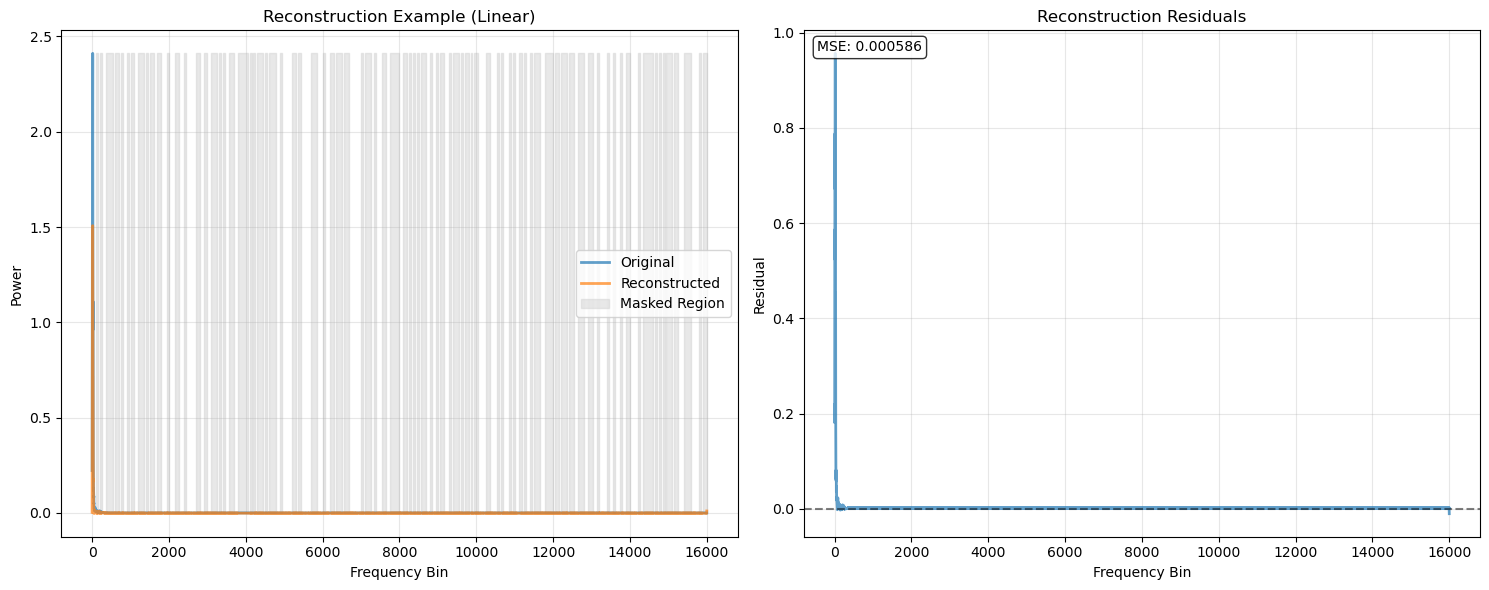

In [74]:
model.eval()

# New test data
loader = DataLoader(dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    sample_batch = next(iter(loader))[:1].to('cpu')
    masked_batch, mask = block_predefined_mask(sample_batch,
                                            block_size=log_data['train_config']['mask_block_size'],
                                            mask_ratio=0.5)
    output = model(masked_batch)

    original = sample_batch[0].cpu().numpy()
    masked = masked_batch[0].cpu().numpy()
    reconstructed = output['reconstructed'][0].cpu().numpy()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Linear scale reconstruction
axes[0].plot(original, label='Original', alpha=0.7, linewidth=2)
axes[0].plot(reconstructed, label='Reconstructed', alpha=0.7, linewidth=2)
# axes[0].plot(masked, label='Masked Input', alpha=0.7, linewidth=2, linestyle='dashed')
axes[0].fill_between(np.arange(len(masked)), original.min(), original.max(), where=mask[0], color="lightgrey",
                     alpha=0.5, step="mid",label='Masked Region')
axes[0].set_xlabel('Frequency Bin')
axes[0].set_ylabel('Power')
axes[0].set_title('Reconstruction Example (Linear)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# axes[0].set_xlim(0,500)

# Residuals
residual = original - reconstructed
axes[1].plot(residual, alpha=0.7, linewidth=2)
axes[1].set_xlabel('Frequency Bin')
axes[1].set_ylabel('Residual')
axes[1].set_title('Reconstruction Residuals')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

mse = np.mean((original - reconstructed) ** 2)
axes[1].text(0.02, 0.98, f'MSE: {mse:.6f}', transform=axes[1].transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()

In [49]:
# DETAILED WALKTHROUGH: Data Transformations Through UNet Layers
print("UNet Data Flow Analysis")
print("="*60)

# Use the configuration from your training
encoder_dims = [32, 64, 128]  # From your current config
num_layers = 3
input_length = 1024

print(f"Configuration:")
print(f"  encoder_dims: {encoder_dims}")
print(f"  num_layers: {num_layers}")
print(f"  input_length: {input_length}")

print("\n" + "="*60)
print("ENCODER FORWARD PASS")
print("="*60)

# Trace through the encoder step by step
batch_size = 32  # Example batch size
current_shape = [batch_size, input_length]
current_length = input_length

print(f"\n0. INPUT:")
print(f"   Shape: {current_shape} → [batch, length]")
print(f"   This gets converted to: [{batch_size}, 1, {input_length}] → [batch, channels, length]")

current_shape = [batch_size, 1, input_length]
current_channels = 1

print(f"\n1. EMBEDDING LAYER:")
print(f"   Input:  [{current_shape[0]}, {current_channels}, {current_length}]")
print(f"   Conv1d: {current_channels} → {encoder_dims[0]} channels (kernel=7, stride=1, padding=3)")
print(f"   Output: [{batch_size}, {encoder_dims[0]}, {current_length}]")
print(f"   ✓ Spatial dimension unchanged: {current_length}")

current_channels = encoder_dims[0]

print(f"\n2. DOWNSAMPLING BLOCKS:")
skip_shapes = []

for i in range(num_layers):
    in_dim = encoder_dims[i] if i < len(encoder_dims) else encoder_dims[-1]
    out_dim = encoder_dims[i+1] if i+1 < len(encoder_dims) else encoder_dims[-1]
    
    print(f"\n   Block {i}:")
    print(f"   ┌─ Input:  [{batch_size}, {in_dim}, {current_length}]")
    
    # Pre-convolution
    print(f"   ├─ Pre-conv: {in_dim} → {out_dim} channels (2 conv layers)")
    print(f"   ├─ After pre-conv: [{batch_size}, {out_dim}, {current_length}]")
    
    # Store skip connection
    skip_shape = [batch_size, out_dim, current_length]
    skip_shapes.append(skip_shape)
    print(f"   ├─ 💾 SKIP CONNECTION STORED: {skip_shape}")
    
    # Downsample
    current_length = current_length // 2
    print(f"   └─ MaxPool (2x downsample): [{batch_size}, {out_dim}, {current_length}]")
    
    current_channels = out_dim

print(f"\n3. BOTTLENECK:")
bottleneck_dim = encoder_dims[-1]
print(f"   Input:  [{batch_size}, {bottleneck_dim}, {current_length}]")
print(f"   Conv layers: {bottleneck_dim} → {bottleneck_dim} (2 conv layers, no size change)")
print(f"   Output: [{batch_size}, {bottleneck_dim}, {current_length}]")

bottleneck_shape = [batch_size, bottleneck_dim, current_length]

print(f"\n📊 ENCODER SUMMARY:")
print(f"   Input size: {input_length} → Bottleneck size: {current_length}")
print(f"   Compression ratio: {input_length // current_length}:1")
print(f"   Skip connections stored: {len(skip_shapes)}")
for i, skip in enumerate(skip_shapes):
    print(f"     Skip {i}: {skip}")

print("\n" + "="*60)
print("DECODER FORWARD PASS")
print("="*60)

# Decoder analysis
decoder_dims = encoder_dims[::-1]  # Reverse for decoder
print(f"Decoder dims (reversed): {decoder_dims}")

current_shape = bottleneck_shape
current_length = bottleneck_shape[2]
current_channels = bottleneck_shape[1]

print(f"\n1. DECODER INPUT (from bottleneck):")
print(f"   Shape: {current_shape}")

print(f"\n2. UPSAMPLING BLOCKS:")

# Skip connections in reverse order for decoder
skip_shapes_reversed = skip_shapes[::-1]

for i in range(num_layers):
    in_dim = decoder_dims[i] if i < len(decoder_dims) else decoder_dims[-1]
    out_dim = decoder_dims[i+1] if i+1 < len(decoder_dims) else decoder_dims[-1]
    
    # Get corresponding skip connection
    skip_shape = skip_shapes_reversed[i]
    skip_channels = skip_shape[1]
    skip_length = skip_shape[2]
    
    print(f"\n   Block {i}:")
    print(f"   ┌─ Input:  [{batch_size}, {in_dim}, {current_length}]")
    
    # Upsample
    current_length *= 2
    print(f"   ├─ ConvTranspose (2x upsample): [{batch_size}, {in_dim}, {current_length}]")
    
    # Skip connection integration
    total_channels = in_dim + skip_channels
    print(f"   ├─ 🔗 Add skip connection: [{batch_size}, {skip_channels}, {skip_length}]")
    print(f"   ├─ Concatenate: [{batch_size}, {total_channels}, {current_length}]")
    print(f"   │   (Upsampled {in_dim} + Skip {skip_channels} = {total_channels} channels)")
    
    # Skip integration convolution
    print(f"   └─ Integration conv: {total_channels} → {out_dim}")
    print(f"       Final: [{batch_size}, {out_dim}, {current_length}]")
    
    current_channels = out_dim

print(f"\n3. FINAL RECONSTRUCTION:")
final_in_dim = decoder_dims[-1] if len(decoder_dims) > 0 else encoder_dims[0]
print(f"   Input:  [{batch_size}, {final_in_dim}, {current_length}]")
print(f"   Conv layers: {final_in_dim} → {final_in_dim//2} → 1")
print(f"   Adaptive pool to target length: {input_length}")
print(f"   Final output: [{batch_size}, {input_length}]")

print(f"\n📊 FULL PIPELINE SUMMARY:")
print(f"   Input:  [{batch_size}, {input_length}] (raw power spectrum)")
print(f"   Bottleneck: [{batch_size}, {bottleneck_dim}, {current_length//4}] (compressed representation)")
print(f"   Output: [{batch_size}, {input_length}] (reconstructed power spectrum)")
print(f"   Total compression at bottleneck: {input_length // (current_length//4)}:1")

print(f"\n🔑 KEY INSIGHTS:")
print(f"   • encoder_dims controls channel progression: {encoder_dims}")
print(f"   • Each downsampling block halves spatial size, increases channels")
print(f"   • Skip connections preserve information at each resolution level")
print(f"   • Decoder reverses the process with skip connection integration")
print(f"   • Final bottleneck preserves spatial structure (unlike global pooling)")

UNet Data Flow Analysis
Configuration:
  encoder_dims: [32, 64, 128]
  num_layers: 3
  input_length: 1024

ENCODER FORWARD PASS

0. INPUT:
   Shape: [32, 1024] → [batch, length]
   This gets converted to: [32, 1, 1024] → [batch, channels, length]

1. EMBEDDING LAYER:
   Input:  [32, 1, 1024]
   Conv1d: 1 → 32 channels (kernel=7, stride=1, padding=3)
   Output: [32, 32, 1024]
   ✓ Spatial dimension unchanged: 1024

2. DOWNSAMPLING BLOCKS:

   Block 0:
   ┌─ Input:  [32, 32, 1024]
   ├─ Pre-conv: 32 → 64 channels (2 conv layers)
   ├─ After pre-conv: [32, 64, 1024]
   ├─ 💾 SKIP CONNECTION STORED: [32, 64, 1024]
   └─ MaxPool (2x downsample): [32, 64, 512]

   Block 1:
   ┌─ Input:  [32, 64, 512]
   ├─ Pre-conv: 64 → 128 channels (2 conv layers)
   ├─ After pre-conv: [32, 128, 512]
   ├─ 💾 SKIP CONNECTION STORED: [32, 128, 512]
   └─ MaxPool (2x downsample): [32, 128, 256]

   Block 2:
   ┌─ Input:  [32, 128, 256]
   ├─ Pre-conv: 128 → 128 channels (2 conv layers)
   ├─ After pre-conv: [3

In [50]:
# PRACTICAL DEMONSTRATION: Actual Model Data Flow
print("\n" + "="*60)
print("LIVE DEMONSTRATION WITH YOUR TRAINED MODEL")
print("="*60)

# Get a sample input
test_input = dataset[:1]  # Single sample
print(f"Input shape: {test_input.shape}")

# Create a custom forward function to show intermediate shapes
def trace_forward(model, x):
    """Trace through model showing shapes at each step"""
    print(f"\n🔍 TRACING FORWARD PASS:")
    
    # Input processing
    if len(x.shape) == 2:
        x = x.unsqueeze(1)
    print(f"1. After input processing: {x.shape}")
    
    # Embedding
    x = model.encoder.embedding(x)
    print(f"2. After embedding: {x.shape}")
    
    # Encoder blocks
    skip_connections = []
    for i, block in enumerate(model.encoder.down_blocks):
        # Pre-conv
        x = block['pre_conv'](x)
        print(f"3.{i}a After pre-conv block {i}: {x.shape}")
        
        # Store skip
        skip_connections.append(x.clone())
        print(f"3.{i}b Skip connection {i} stored: {x.shape}")
        
        # Downsample
        x = block['downsample'](x)
        print(f"3.{i}c After downsampling {i}: {x.shape}")
    
    # Bottleneck
    bottleneck = model.encoder.bottleneck(x)
    print(f"4. After bottleneck: {bottleneck.shape}")
    
    # Decoder
    x = bottleneck
    skip_connections_reversed = skip_connections[::-1]
    
    for i, (block, skip) in enumerate(zip(model.decoder.up_blocks, skip_connections_reversed)):
        print(f"\n   Decoder block {i}:")
        
        # Upsample
        x = block['upsample'](x)
        print(f"   5.{i}a After upsample: {x.shape}")
        
        # Interpolate skip if needed
        if x.shape[-1] != skip.shape[-1]:
            import torch.nn.functional as F
            skip = F.interpolate(skip, size=x.shape[-1], mode='linear', align_corners=False)
            print(f"   5.{i}b Skip interpolated to: {skip.shape}")
        
        # Concatenate
        x_cat = torch.cat([x, skip], dim=1)
        print(f"   5.{i}c After concatenation: {x_cat.shape}")
        
        # Skip integration
        x = block['skip_integrate'](x_cat)
        print(f"   5.{i}d After integration: {x.shape}")
    
    # Final reconstruction
    x = model.decoder.final_conv(x)
    print(f"6. After final conv: {x.shape}")
    
    x = model.decoder.adaptive_pool(x)
    print(f"7. After adaptive pool: {x.shape}")
    
    return x.squeeze(1)

# Run the trace
model.eval()
with torch.no_grad():
    result = trace_forward(model, test_input)
    print(f"\nFinal output shape: {result.shape}")

print(f"\n📈 COMPRESSION ANALYSIS:")
input_size = test_input.shape[-1]
# Get bottleneck size from model
with torch.no_grad():
    temp_input = test_input.unsqueeze(1)
    temp_encoded, _ = model.encoder(temp_input)
    bottleneck_spatial_size = temp_encoded.shape[-1]
    bottleneck_channels = temp_encoded.shape[1]
    
print(f"Input length: {input_size}")
print(f"Bottleneck spatial size: {bottleneck_spatial_size}")
print(f"Bottleneck channels: {bottleneck_channels}")
print(f"Spatial compression ratio: {input_size // bottleneck_spatial_size}:1")
print(f"Total values: {input_size} → {bottleneck_channels * bottleneck_spatial_size}")
print(f"Information density change: {(bottleneck_channels * bottleneck_spatial_size) / input_size:.2f}x")

print(f"\n💡 ENCODER_DIMS EXPLANATION:")
print(f"encoder_dims = {model_config['encoder_dims']} means:")
print(f"  • Start with 1 channel (raw power spectrum)")
print(f"  • Embedding: 1 → {model_config['encoder_dims'][0]} channels")
for i in range(len(model_config['encoder_dims']) - 1):
    input_dim = model_config['encoder_dims'][i]
    output_dim = model_config['encoder_dims'][i + 1]
    spatial_size = input_size // (2 ** (i + 1))
    print(f"  • Block {i}: {input_dim} → {output_dim} channels, spatial size ÷2 = {spatial_size}")
final_spatial_size = input_size // (2 ** len(model_config['encoder_dims']))
print(f"  • Final bottleneck: {model_config['encoder_dims'][-1]} channels × {final_spatial_size} spatial = {model_config['encoder_dims'][-1] * final_spatial_size} total values")


LIVE DEMONSTRATION WITH YOUR TRAINED MODEL
Input shape: torch.Size([1, 1024])

🔍 TRACING FORWARD PASS:
1. After input processing: torch.Size([1, 1, 1024])
2. After embedding: torch.Size([1, 32, 1024])
3.0a After pre-conv block 0: torch.Size([1, 64, 1024])
3.0b Skip connection 0 stored: torch.Size([1, 64, 1024])
3.0c After downsampling 0: torch.Size([1, 64, 512])
3.1a After pre-conv block 1: torch.Size([1, 128, 512])
3.1b Skip connection 1 stored: torch.Size([1, 128, 512])
3.1c After downsampling 1: torch.Size([1, 128, 256])
3.2a After pre-conv block 2: torch.Size([1, 128, 256])
3.2b Skip connection 2 stored: torch.Size([1, 128, 256])
3.2c After downsampling 2: torch.Size([1, 128, 128])
4. After bottleneck: torch.Size([1, 128, 128])

   Decoder block 0:
   5.0a After upsample: torch.Size([1, 128, 256])
   5.0c After concatenation: torch.Size([1, 256, 256])
   5.0d After integration: torch.Size([1, 64, 256])

   Decoder block 1:
   5.1a After upsample: torch.Size([1, 64, 512])
   5.1c A

VISUAL ARCHITECTURE SUMMARY
UNet Architecture Diagram:

INPUT
[1024] ────┐
                     │
                  EMBEDDING
                [1→32, 1024]
                     │
                 BLOCK 0
              [32→64, 1024]
                     │
                  ┌─SKIP─┐  (64 channels)
                  │     │
               POOL 2x  │  (spatial: 1024→512)
                  │     │
                 BLOCK 1
              [64→128, 512]
                     │
                  ┌─SKIP─┐  (128 channels)
                  │     │
               POOL 2x  │  (spatial: 512→256)
                  │     │
                BOTTLENECK
             [128, 256]
                     │
               UPSAMPLE 2x
            [128, 256→512]
                  │
                  ├─SKIP─┘  (64 channels)
               CONCAT & CONV
           [128+64→64, 512]
                  │
               UPSAMPLE 2x
            [64, 512→1024]
                  │
                  ├─SKIP─┘  (32 channels)
     

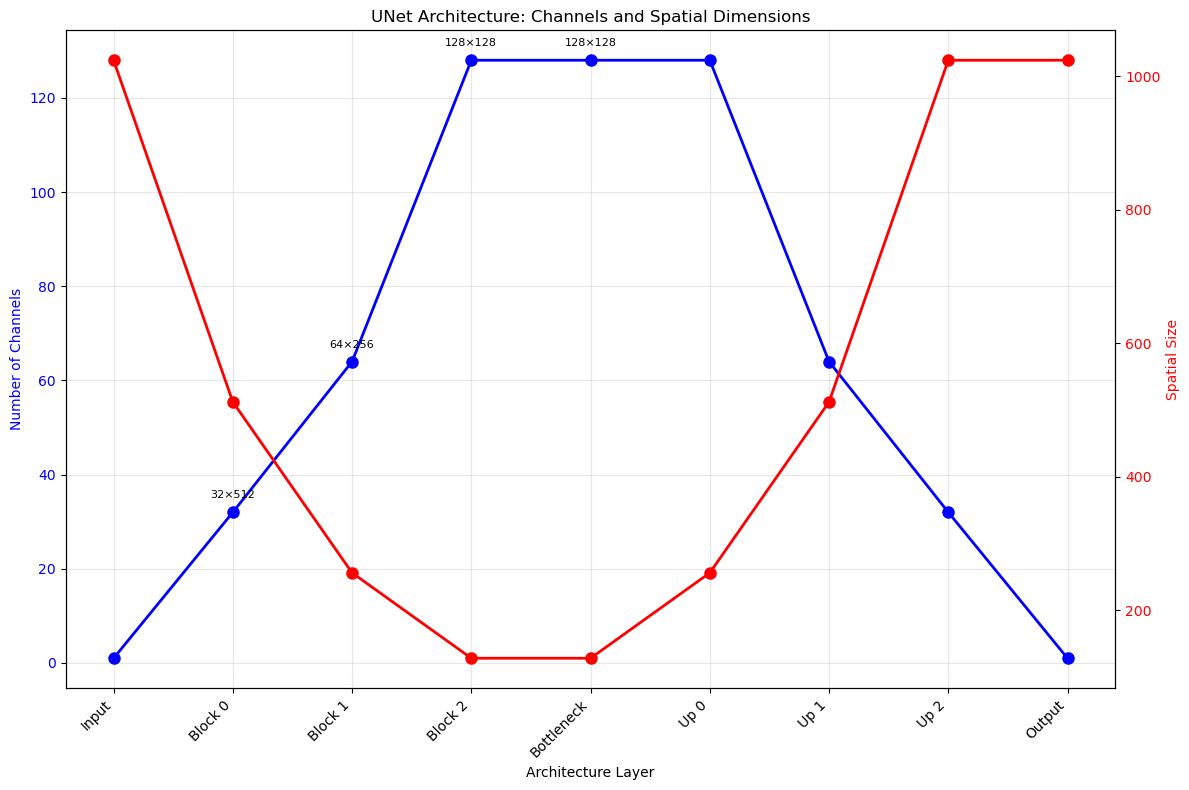

In [51]:
# VISUAL SUMMARY: UNet Architecture
print("VISUAL ARCHITECTURE SUMMARY")
print("="*60)

encoder_dims = model_config['encoder_dims']
input_length = model_config['input_length']

print("UNet Architecture Diagram:")
print()
print("INPUT")
print(f"[{input_length}] ────┐")
print("                     │")
print("                  EMBEDDING")
print(f"                [1→{encoder_dims[0]}, {input_length}]")
print("                     │")

# Encoder
current_length = input_length
for i in range(len(encoder_dims) - 1):
    in_dim = encoder_dims[i]
    out_dim = encoder_dims[i + 1]
    current_length //= 2
    
    print(f"                 BLOCK {i}")
    print(f"              [{in_dim}→{out_dim}, {current_length*2}]")
    print("                     │")
    print(f"                  ┌─SKIP─┐  ({out_dim} channels)")
    print("                  │     │")
    print(f"               POOL 2x  │  (spatial: {current_length*2}→{current_length})")
    print("                  │     │")

print("                BOTTLENECK")
print(f"             [{encoder_dims[-1]}, {current_length}]")
print("                     │")

# Decoder
decoder_dims = encoder_dims[::-1]
for i in range(len(decoder_dims) - 1):
    in_dim = decoder_dims[i]
    out_dim = decoder_dims[i + 1]
    current_length *= 2
    skip_dim = encoder_dims[len(encoder_dims) - 2 - i]
    
    print("               UPSAMPLE 2x")
    print(f"            [{in_dim}, {current_length//2}→{current_length}]")
    print("                  │")
    print(f"                  ├─SKIP─┘  ({skip_dim} channels)")
    print(f"               CONCAT & CONV")
    print(f"           [{in_dim}+{skip_dim}→{out_dim}, {current_length}]")
    print("                  │")

print("              FINAL CONV")
print(f"             [{decoder_dims[-1]}→1, {input_length}]")
print("                  │")
print("                OUTPUT")
print(f"               [{input_length}]")

print("\n" + "="*60)
print("KEY RELATIONSHIPS:")
print("="*60)
print(f"• encoder_dims = {encoder_dims}")
print(f"• Each value represents output channels after that block")
print(f"• Spatial dimensions halve at each downsampling: {input_length} → {input_length//2} → {input_length//4} → {input_length//8}")
print(f"• Skip connections preserve multi-scale information")
print(f"• Bottleneck has {encoder_dims[-1]} channels × {input_length // (2**len(encoder_dims))} spatial")
print(f"• Total bottleneck parameters: {encoder_dims[-1] * (input_length // (2**len(encoder_dims)))} vs input {input_length}")
print(f"• Compression ratio: {(encoder_dims[-1] * (input_length // (2**len(encoder_dims)))) / input_length:.2f}x information density")

# Create a simple visualization
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot the architecture flow
levels = ['Input'] + [f'Block {i}' for i in range(len(encoder_dims))] + ['Bottleneck'] + [f'Up {i}' for i in range(len(encoder_dims))] + ['Output']
channels = [1] + encoder_dims + [encoder_dims[-1]] + encoder_dims[::-1] + [1]
spatial_sizes = [input_length]

# Calculate spatial sizes
temp_size = input_length
for i in range(len(encoder_dims)):
    temp_size //= 2
    spatial_sizes.append(temp_size)
spatial_sizes.append(temp_size)  # Bottleneck

# Decoder spatial sizes
for i in range(len(encoder_dims)):
    temp_size *= 2
    spatial_sizes.append(temp_size)
spatial_sizes.append(input_length)  # Output

# Plot
x_positions = range(len(levels))
ax.plot(x_positions, channels, 'bo-', linewidth=2, markersize=8, label='Channels')
ax.set_xlabel('Architecture Layer')
ax.set_ylabel('Number of Channels', color='b')
ax.tick_params(axis='y', labelcolor='b')
ax.set_xticks(x_positions)
ax.set_xticklabels(levels, rotation=45, ha='right')

# Add spatial size on second y-axis
ax2 = ax.twinx()
ax2.plot(x_positions, spatial_sizes, 'ro-', linewidth=2, markersize=8, label='Spatial Size')
ax2.set_ylabel('Spatial Size', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add annotations
for i, (level, ch, spatial) in enumerate(zip(levels, channels, spatial_sizes)):
    if 'Block' in level or level == 'Bottleneck':
        ax.annotate(f'{ch}×{spatial}', (i, ch), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

ax.set_title('UNet Architecture: Channels and Spatial Dimensions')
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()